# Analysis of APT data (statistical distributions)

**System**
* Alloy composition: $Al_{0.1}CoCrFeNi$
* Lattice: FCC
* Lattice constant: 3.57A

**APT measurement**
* Detector efficiency: 33%
* position uncertainty (standard deviation): 5A (in all directions?)

## Setup

In [1]:
# Notebook settings

# code development settings (automatically reload modified modules)
%load_ext autoreload
%autoreload 2

# plotting backend
%matplotlib inline

In [79]:
# basic libraries

import os, sys
import re
import copy
from itertools import product
# from collections import Counter
import numpy as np
#import scipy.io
from scipy.stats import multinomial, binom
from scipy.optimize import fmin
from sklearn.neighbors import NearestNeighbors

# plotting
import matplotlib.pyplot as plt

# data handling
# import pyUSID as usid
# import h5py
# import pandas as pd
# import xarray as xr

# parallelization
# from subprocess import Popen, PIPE
# import multiprocessing as mp

In [81]:
# local library
sys.path.append('../../../force_fields/statmechlib')
from statmechlib.read_write import read_lattice_model, read_modeldef, write_modeldef
from statmechlib.preprocessing import get_stats_latt, cfg_replicate
from statmechlib.forcefields import sd2

In [4]:
# project directories
data_raw = '../data/target_raw'
src_dir = '../src'
sim_dir = '../sim'

## Read target data

In [22]:
# compositions, concentrations, atom types
element = ['Al','Co','Cr','Fe','Ni']
composition = [0.1, 1.0, 1.0, 1.0, 1.0]
mol_fractions = np.array(composition)/sum(composition)
ntype = len(mol_fractions)

# numbers of KNNs of a particular atom i of type ti
knn = [2, 5, 10, 20, 40, 100, 200, 500, 1000]

# directories containing data for different KNNs
knn_dirs = [os.path.join(data_raw, 'K'+str(k)) for k in knn]

print(knn_dirs)

['../data/target_raw/K2', '../data/target_raw/K5', '../data/target_raw/K10', '../data/target_raw/K20', '../data/target_raw/K40', '../data/target_raw/K100', '../data/target_raw/K200', '../data/target_raw/K500', '../data/target_raw/K1000']


In [23]:
# functions to read data files with pairwise statistics

def read_pairwise(file_name, nn):
    """
    Parameters
    ----------
    file_name: str
        Input file with pairwise statistics
    nn: int
        number of nearest neighbors
    
    Returns
    -------
    stats: ndarray(5,5,nn)
        all pairwise statistics for 5 atom types
    """
    
    # output array
    stats = np.zeros((ntype, ntype, nn), dtype=int)
    
    # regex to extract particle types
    atom_info = re.compile(r'IonType\s*(\d+)\s*,\s*type\s*(\d+)\s+')
    
    with open(file_name, 'r') as fin:
        for line in iter(fin.readline, ''):
            m = atom_info.search(line)
            i, j = [int(c) for c in m.groups()]

            counts = re.findall('\d+', fin.readline())
            #print(i, j, len(counts))
            stats[i, j, :] = [int(c) for c in counts]

    return stats

In [24]:
targets = {}
for d, k in zip(knn_dirs, knn):
    targets[k] = read_pairwise(os.path.join(d, f'RamaTest_PatternK{k}_PairWise'), k)

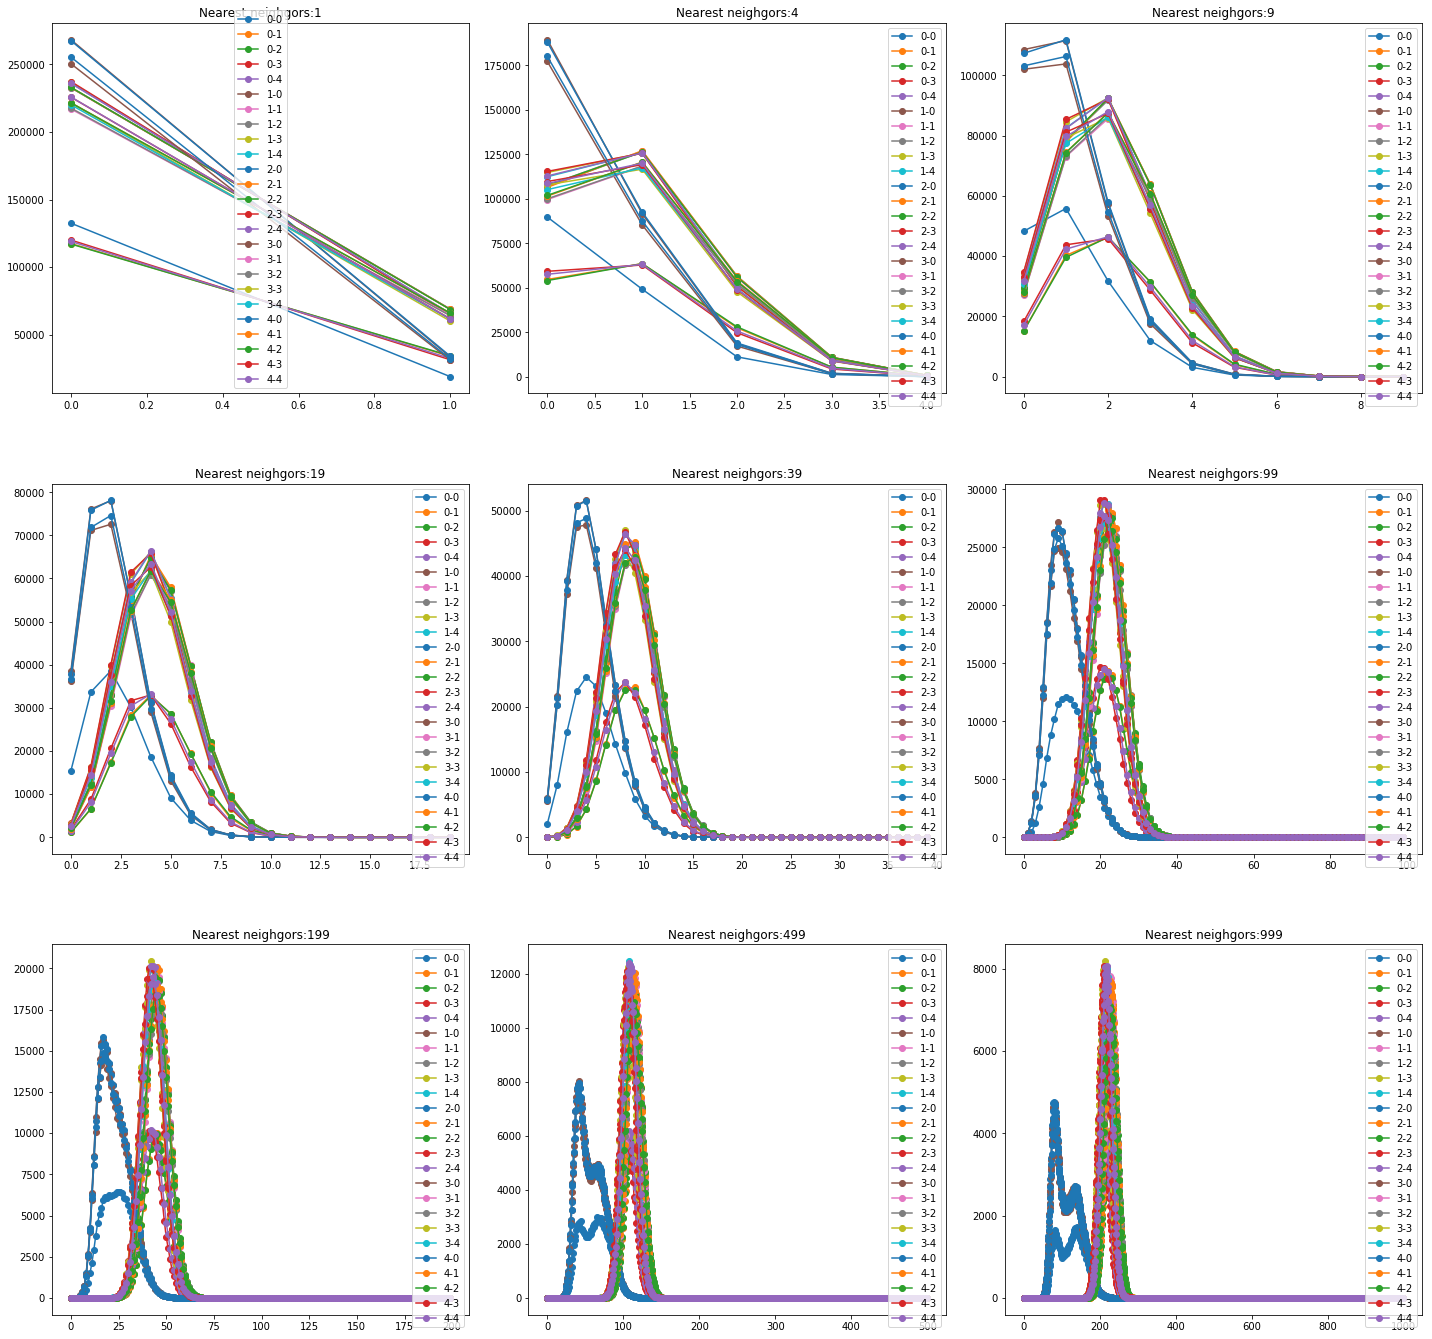

In [25]:
# Plot all distributions

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20,20))

for c, (key, targ) in enumerate(targets.items()):

    pi, pj = divmod(c, 3)
    for i, j in product(range(ntype), repeat=2):
        #if (i*j == 0) and not (i+j == 0):
        #    continue
        axes[pi, pj].plot(np.arange(targ.shape[2]), targ[i,j,:], 'o-', label=str(i)+'-'+str(j))
    axes[pi,pj].legend()
    axes[pi,pj].set_title('Nearest neighgors:'+str(key-1))

#plt.title("Atom-atom count distributions for different atom types and KNNs")
plt.tight_layout()

In [47]:
# Get alloy concentration from the counts
counts = np.zeros((ntype, ), dtype = float)
conc = np.zeros((ntype), dtype=float)

for key, targ in targets.items():
    for it in range(ntype):
        counts[it] = np.sum(targ[it, 0])
        #print(key, it, np.sum(targ[it, 0]))
        conc[it] = counts[it]

    #print(counts, counts/counts[1])
    conc = counts/np.sum(counts)

tot_counts = np.sum(counts)
print(conc*tot_counts)
print(counts, tot_counts)
print(conc)

[151542. 301717. 301693. 281721. 287533.]
[151542. 301717. 301693. 281721. 287533.] 1324206.0
[0.1144399  0.22784748 0.22782936 0.21274711 0.21713616]


## Generate random distributions (null hypothesis)

* Assume that there are no interactioins between particles and for each KNN generate multinomial distributions with parameters (probabilities) set to mole fractions.

In [27]:
# set probabilities to mole fractions
probs = copy.copy(conc)
print(probs)
print(counts)

[0.1144399  0.22784748 0.22782936 0.21274711 0.21713616]
[151542. 301717. 301693. 281721. 287533.]


In [28]:
def get_marginals(k, probs):
    
    probs_null = np.zeros((ntype, ntype, k), dtype=float)

    # marginal distributions for selected atoms (equivalent to binomial distributions)
    for it in range(ntype):
        for jt in range(ntype):
            bn = binom(n=k-1, p=probs[jt])
            pmf_bn = probs[it]*bn.pmf(range(k))
            probs_null[it, jt, :] = pmf_bn
            #print(k, it, jt, pmf_bn)
    
    return probs_null

In [57]:
null_reference = {}
null_counts = {}
for d, k in zip(knn_dirs, knn):
    null_reference[k] = get_marginals(k, probs)
    null_counts[k] = null_reference[k]*tot_counts

In [30]:
# for k in knn:
#     # a sample from a multinomial distribution
#     x = np.random.multinomial(k-1, probs, size=1)[0]
    
#     # probability mass function at that sample (using scipy)
#     mn = multinomial(n=k-1, p=probs)
#     pmf_mn = mn.pmf(x)

In [97]:
# Function to compare target data with a generated distribution,
# outputing information such as statistical distancd, likelihood, p-values 

def compare_dists(key, targ, null, plot=True):
        
    ntype = targ.shape[0]
    fig, axes = plt.subplots(nrows=ntype, ncols=ntype, figsize=(20,20))
    
    for i, j in product(range(ntype), repeat=2):
        
        tg = targ[i,j,:]/tot_counts/conc[i]
        nl = null[i,j,:]/tot_counts/conc[i]
        
        # get average counts in the neighborhood
        tg_ave = round(sum([i*p for i, p in enumerate(tg)]), 2)
        nl_ave = round(sum([i*p for i, p in enumerate(nl)]), 2)
        
        title_str = 'NN:' + str(key) + ';' + 'Elem.:' + element[i] + element[j]
        title_str += '\nAveNN targ:' + str(tg_ave) + ', rand:' + str(nl_ave)
        axes[i,j].set_title(title_str)
        
        axes[i, j].plot(np.arange(targ.shape[2]), tg, '.--', label='experiment')
        axes[i, j].plot(np.arange(targ.shape[2]), nl, '.--', label='random (binomial)')
        axes[i,j].legend()

    #plt.title("Atom-atom count distributions for different atom types and KNNs")
    plt.tight_layout()
    #s2 = 0.0
    
    #return s2

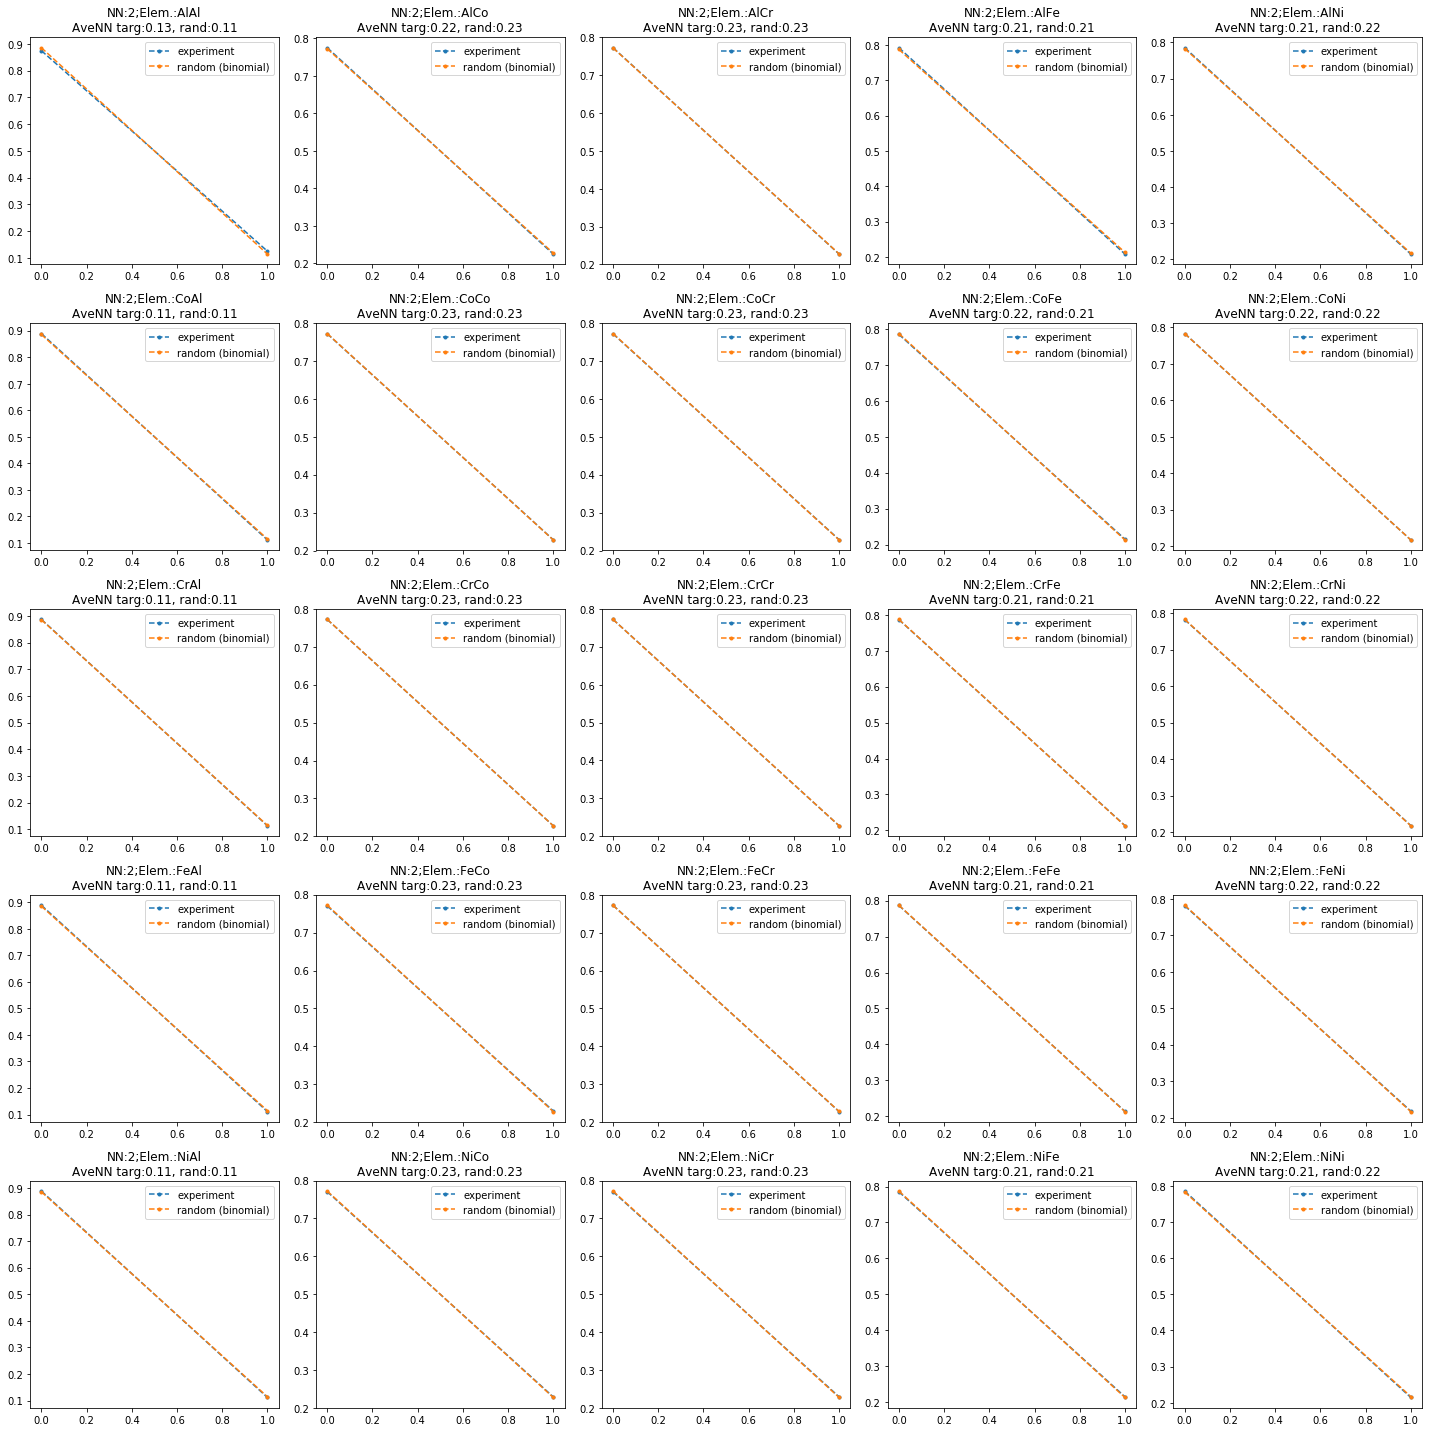

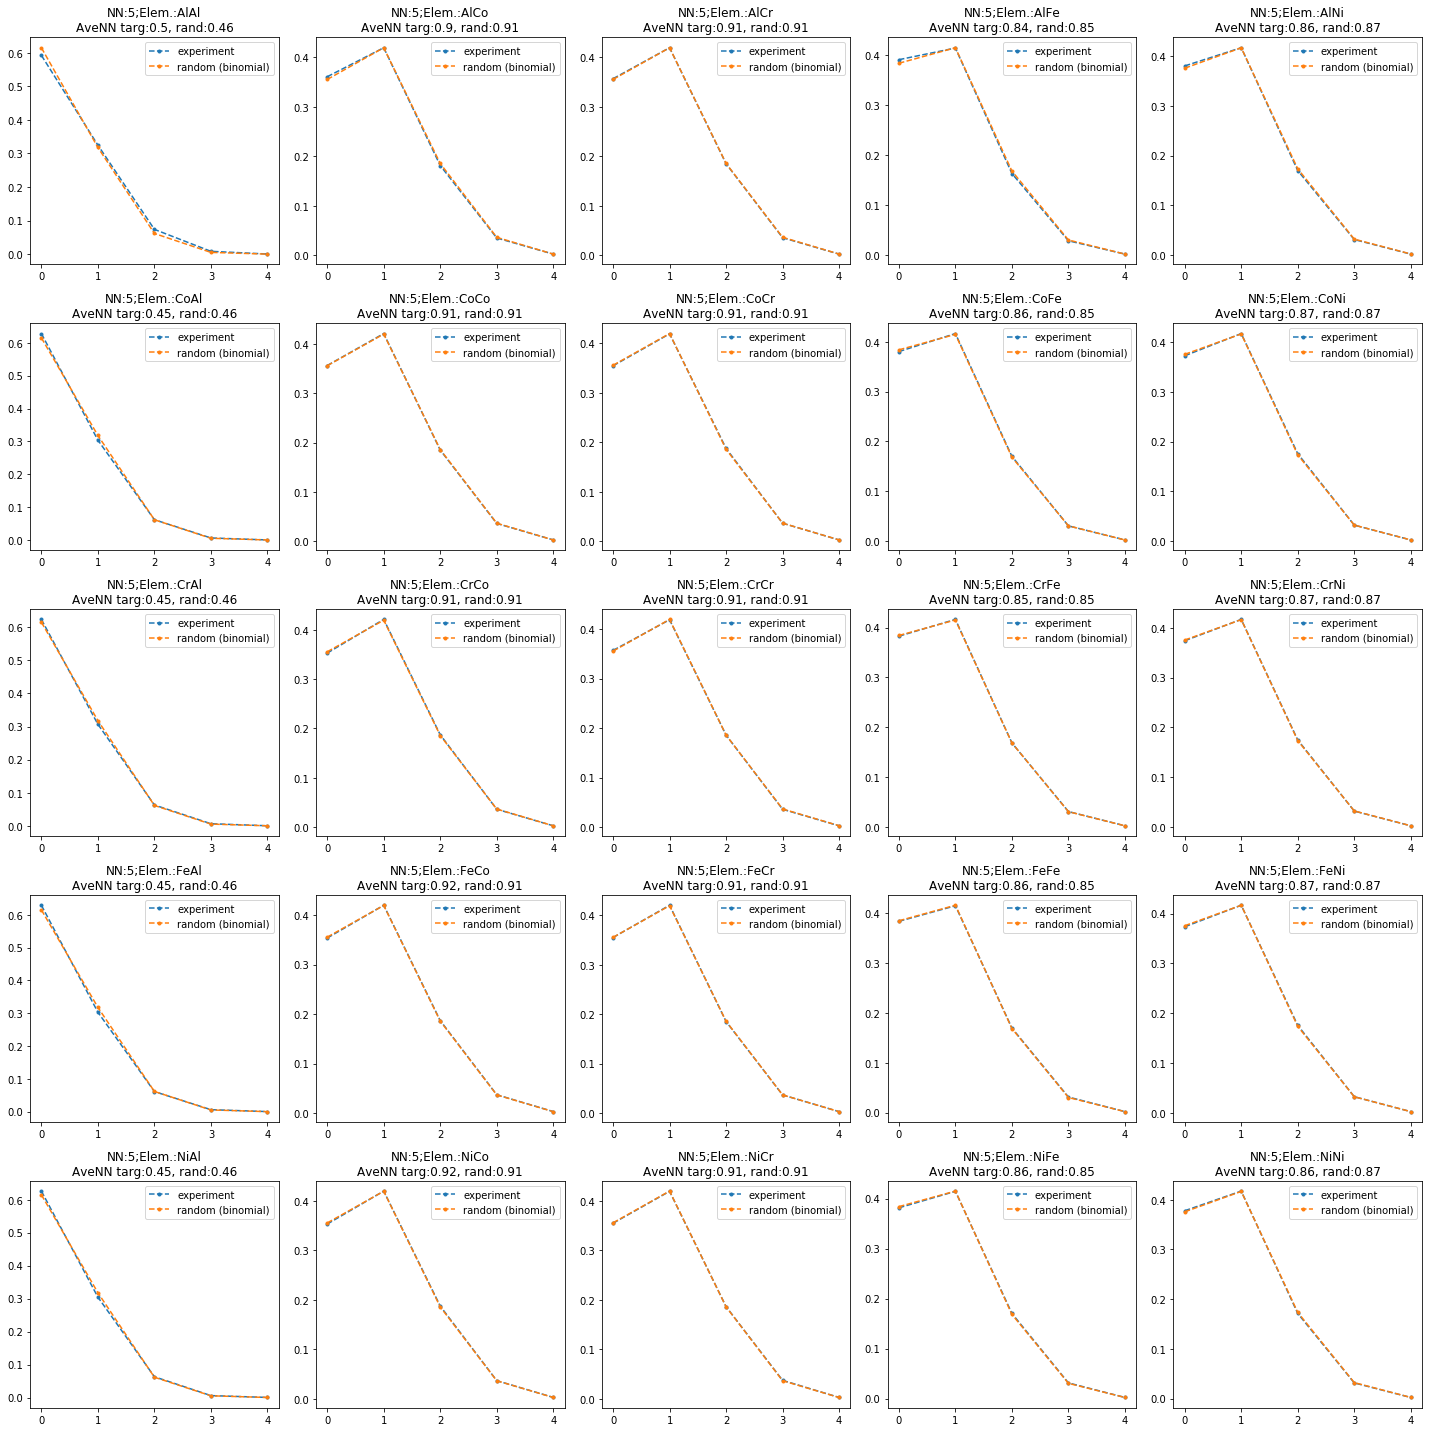

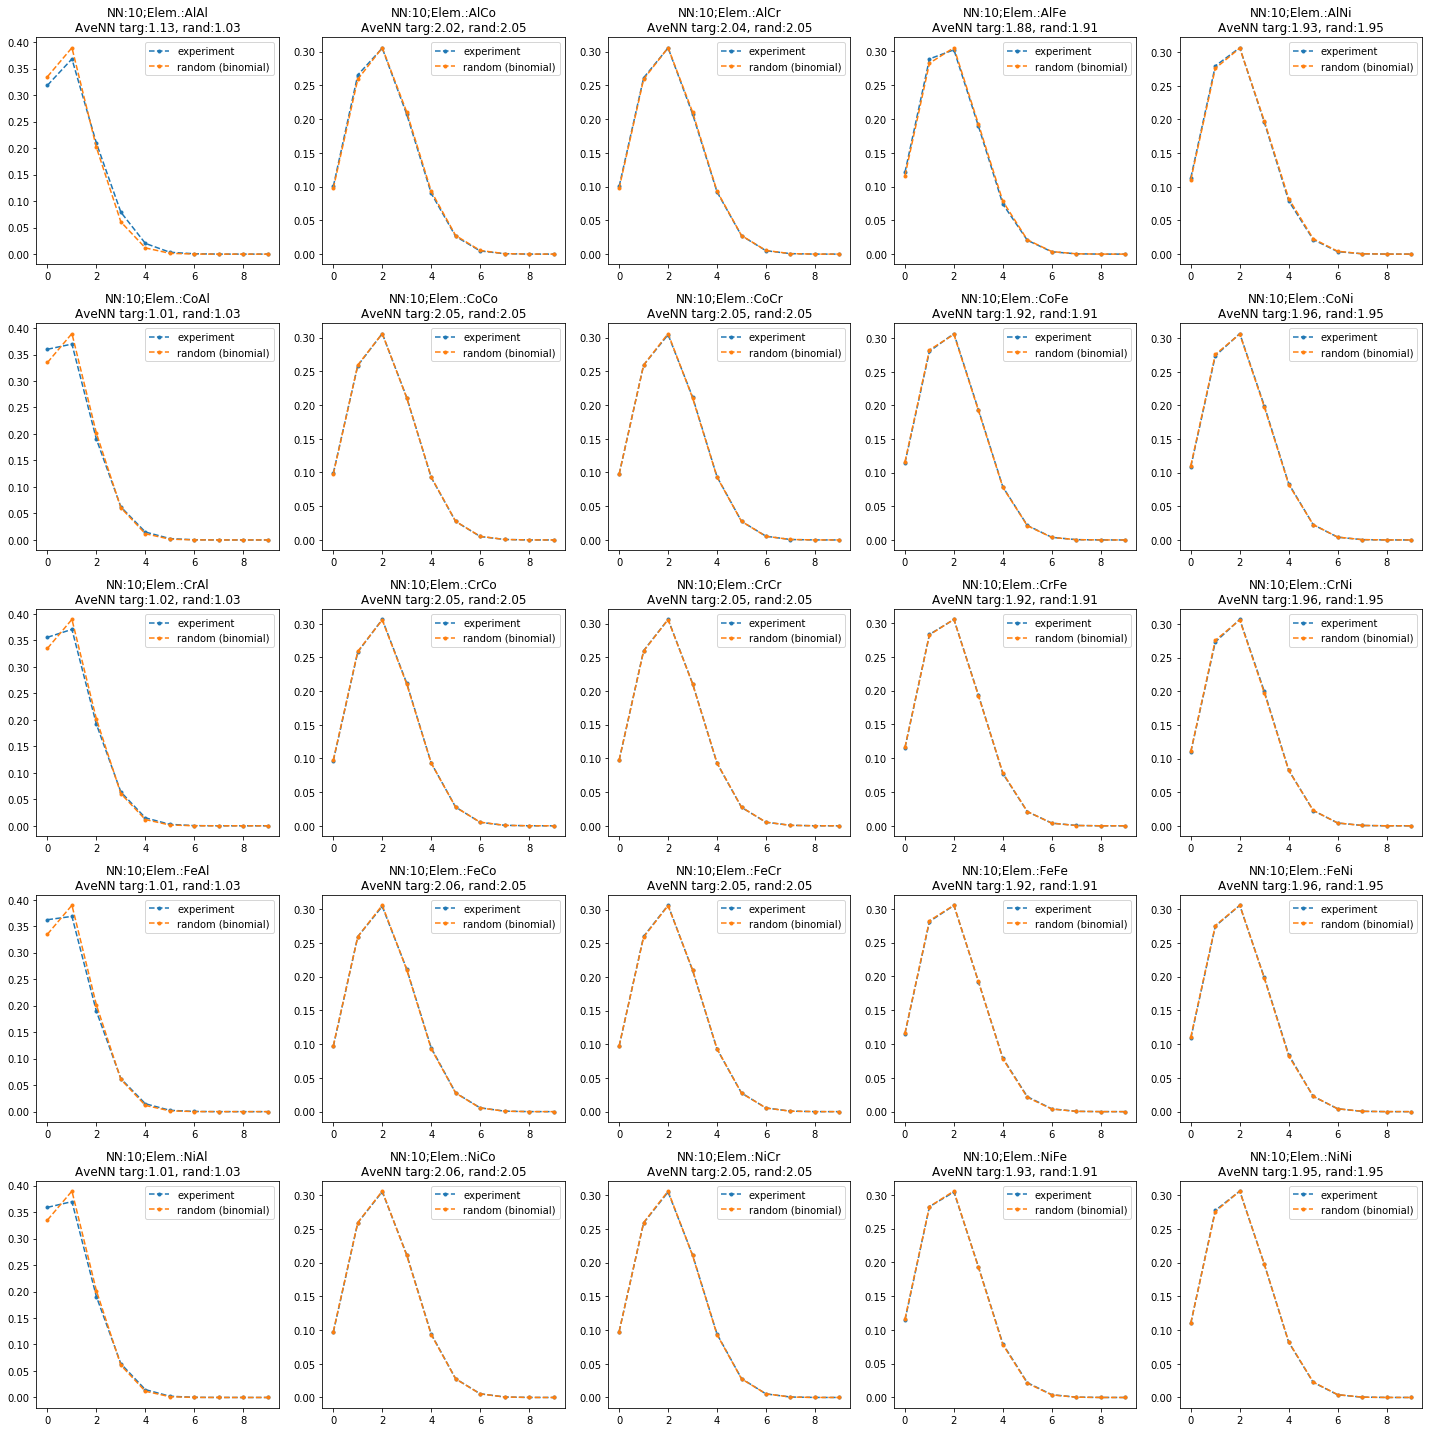

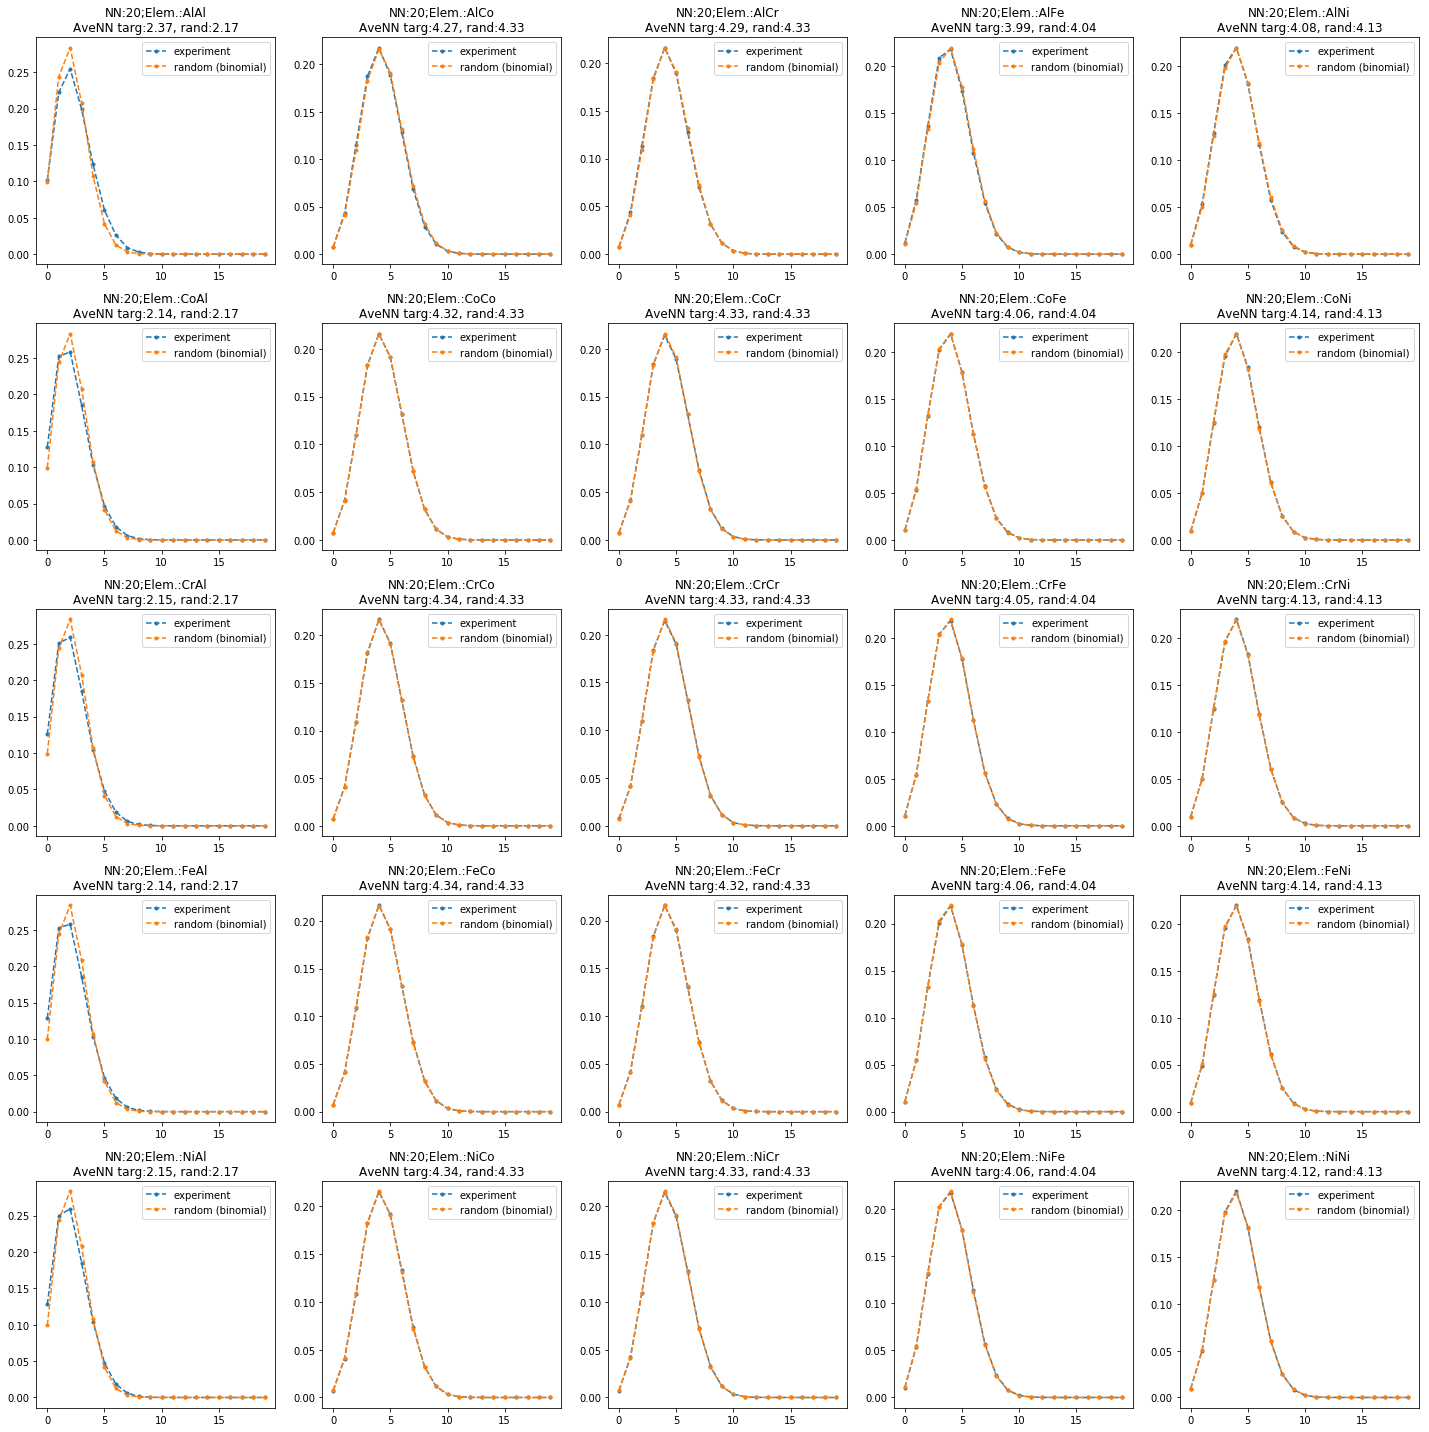

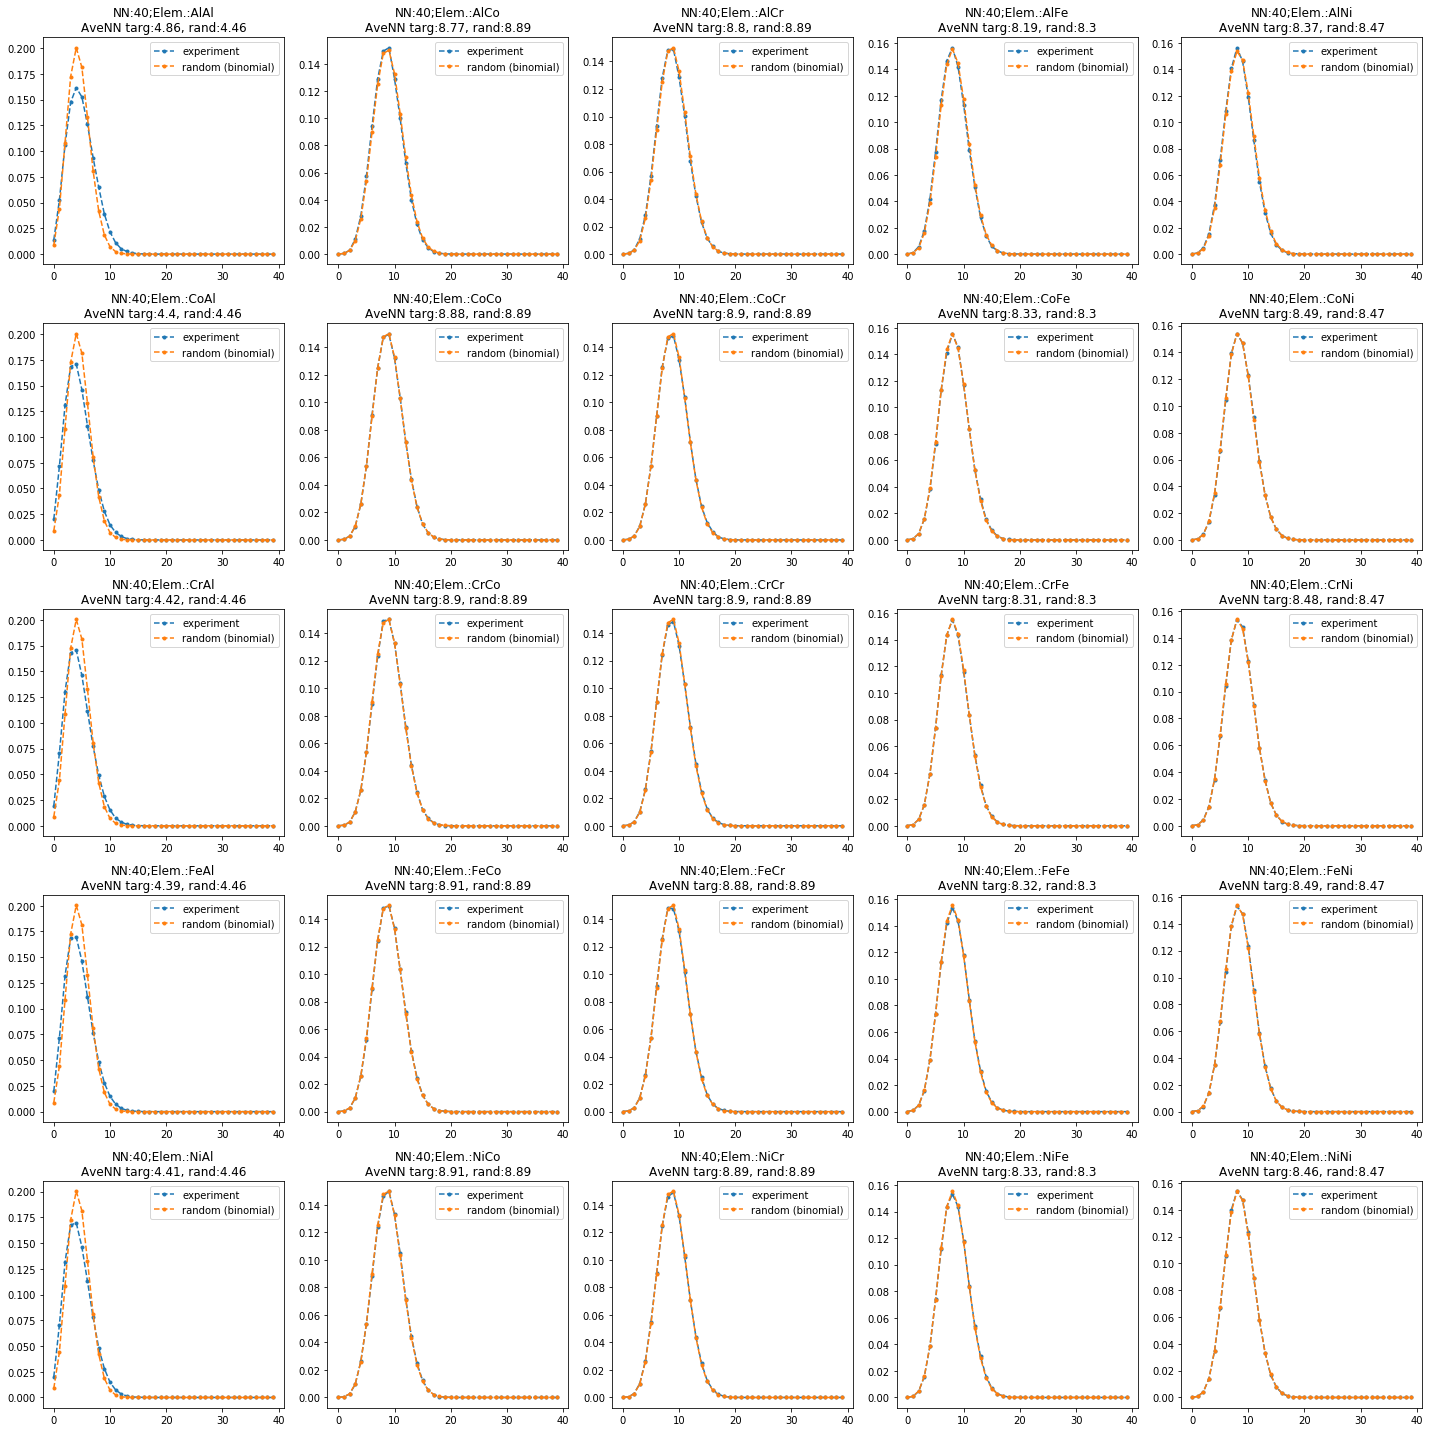

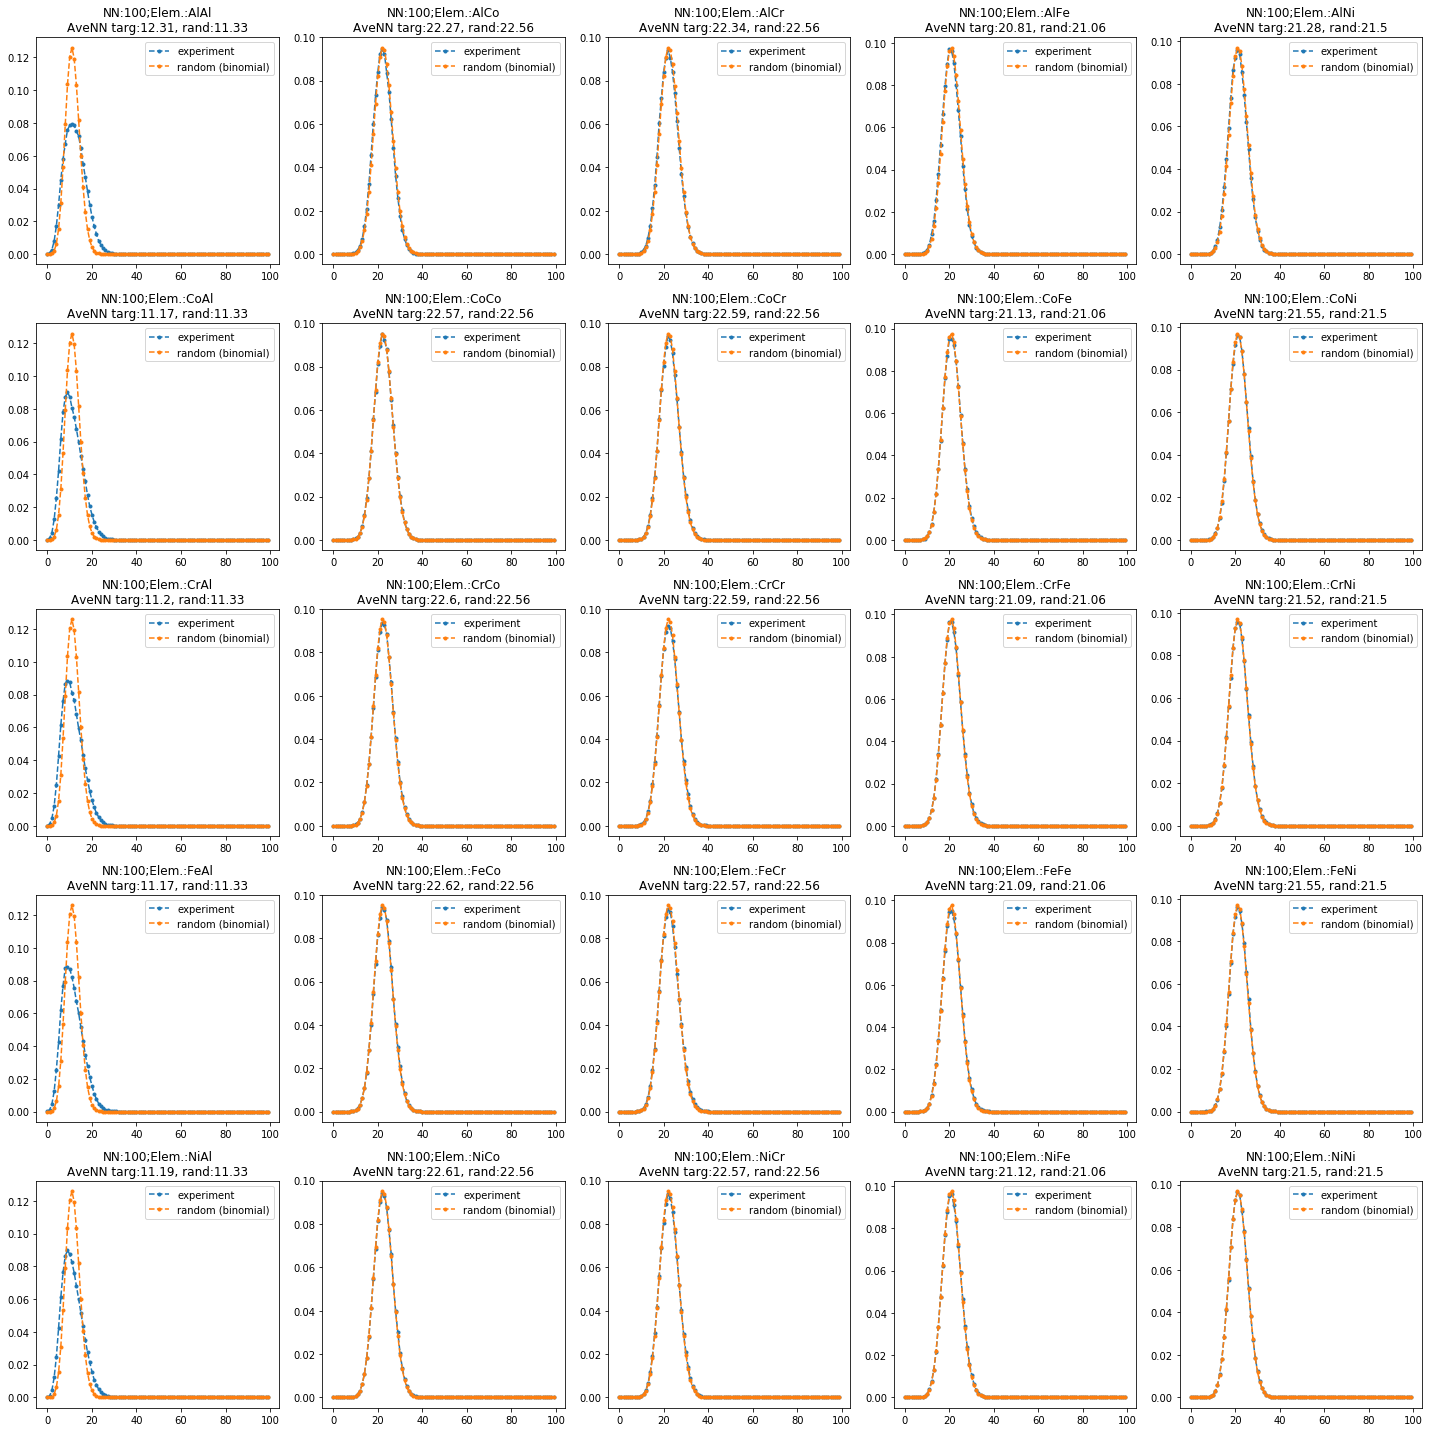

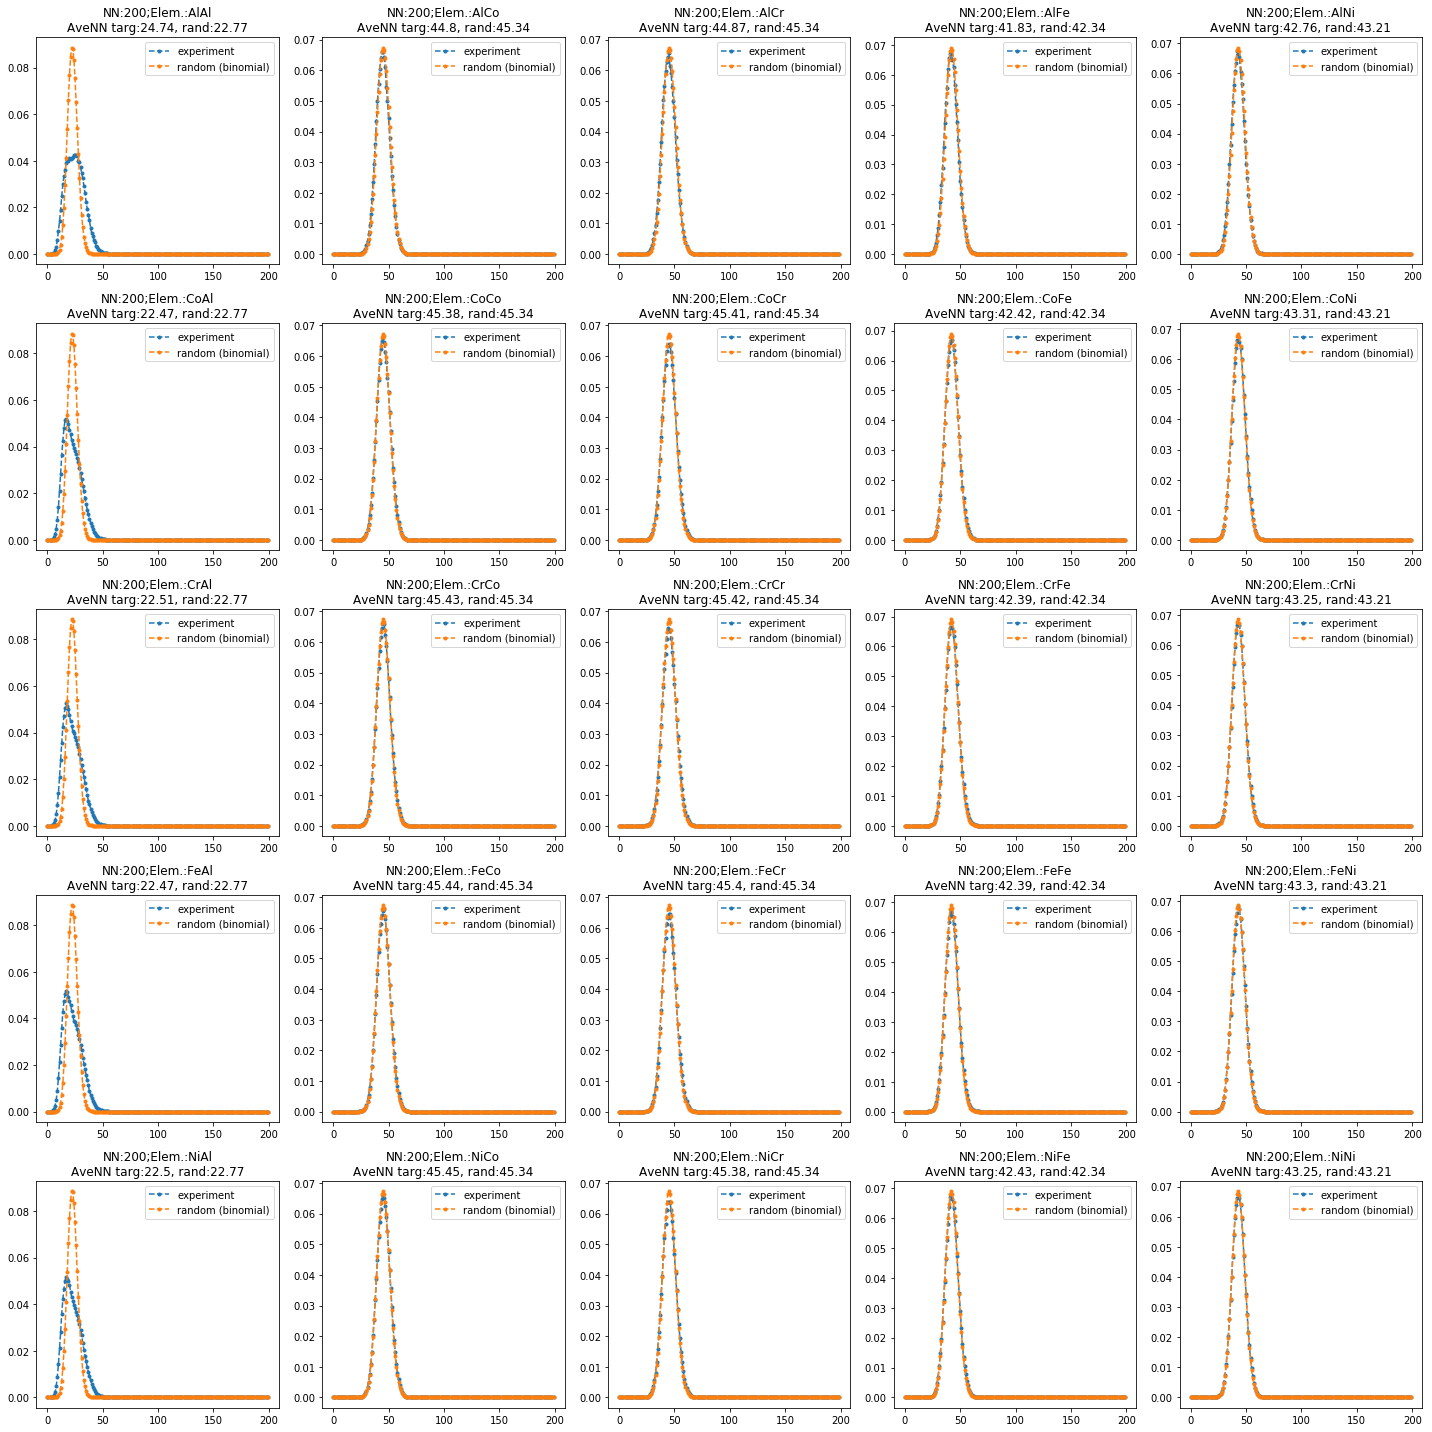

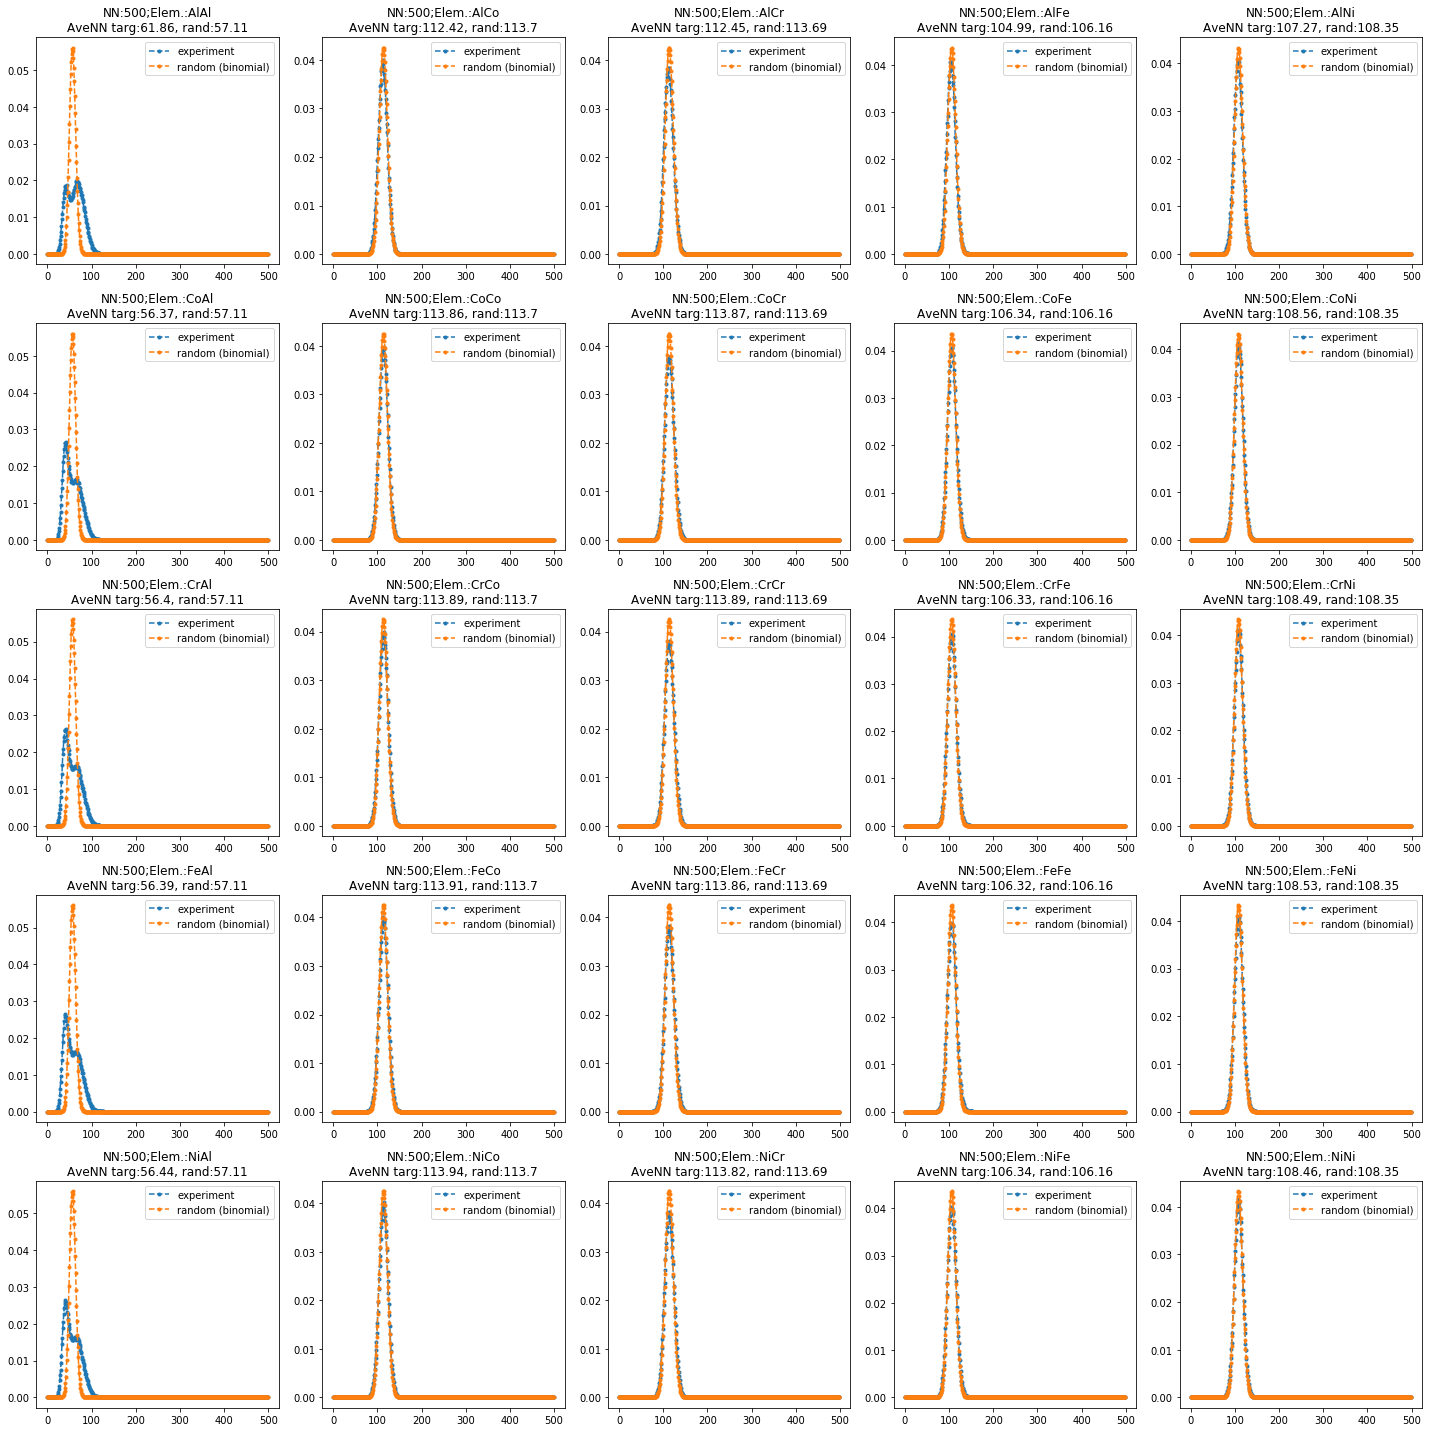

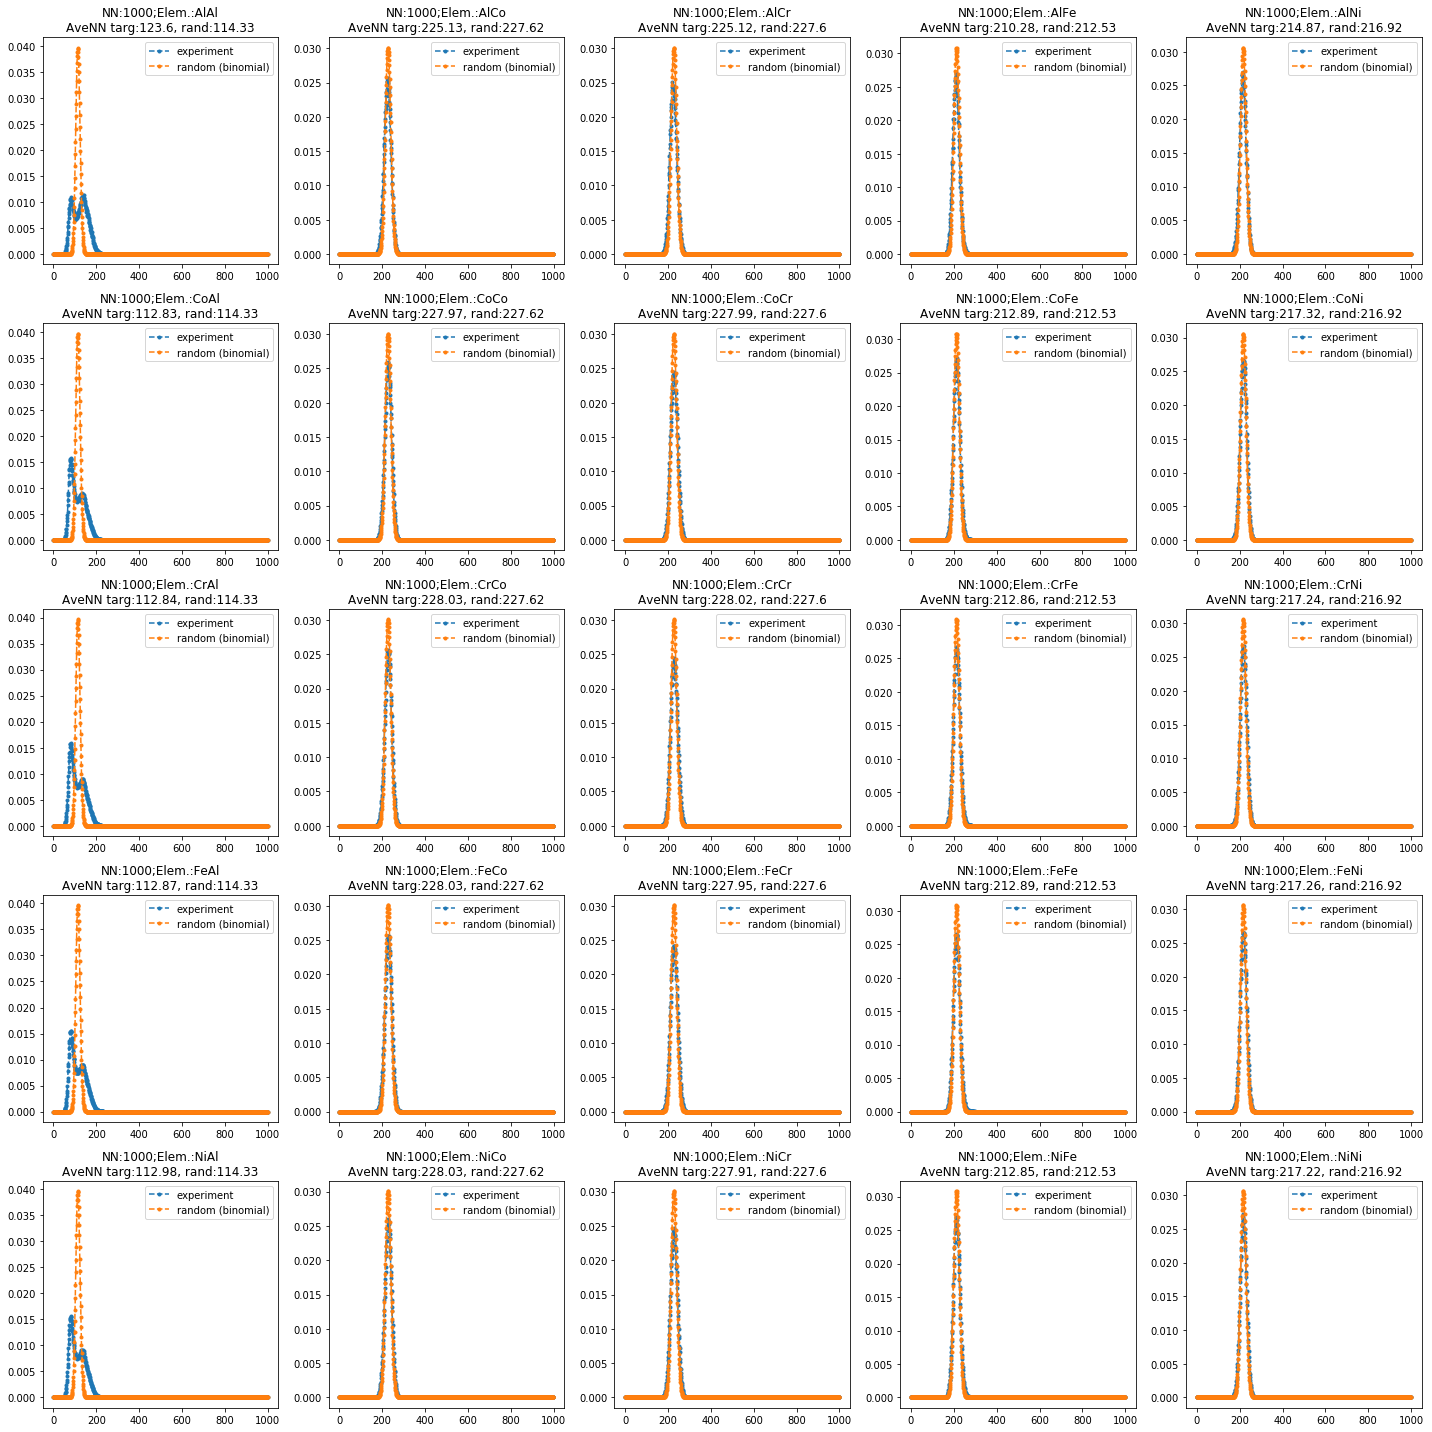

In [98]:
for k in targets:
    compare_dists(k, targets[k], null_counts[k])

## Convolute simulation data

In [82]:
def conf_to_real_units(config_file, scale):

    """
    Read xyz file and return rescaled atomic configurations and (orthogonal) box dimensions
    """

    with open(config_file, 'r') as f:
        
        nat = int(re.findall('\S+', f.readline())[0])
        box = np.diag(np.array([float(l)*scale for l in re.findall('\S+', f.readline())]))
        
        ti = []
        xyz = []
        for line in iter(f.readline, ''):
            items = re.findall('\S+', line)
            ti.append(int(items[0]))
            xyz.append(np.array([float(x)*scale for x in items[1:]]))
    
    return xyz, ti, box

In [83]:
def add_experimental_noise(xyz_in, ti_in, box=None, loss_rate=0.0, disp=0.0):
    """
    Apply random noise emulating APT experiment.
    Includes missing atoms (only 33% retained) and random displacement.
    
    Parameters
    ----------
    xyz_in: list of ndarrays
        list of atom coordinates
    box: ndarray (3x3)
        box dimensions
    loss_rate: float or list of floats
        loss rate, overall (float) or per atom type (list)
    disp: float
        random displacement of atoms: standar deviation of a Gaussian distribution
        
    Returns
    -------
    config_out: ndarray
        list of atoms and their coordinates in xyz format (type, x)
    """    
    
    xyz_out = []
    ti_out = []
    if box:
        boxv = np.diag(box)
    
    for r, t in zip(xyz_in, ti_in):
        
        # Step 1: remove a given fraction of particles
        if np.random() < loss_rate:
            continue

        # Step 2: displace atoms using Gaussian noise
        r += np.random.normal(loc=0.0, scale=disp, size=3)

        # adjust positions using periodic boundary conditions
        if boxv:
            r = np.where(r < 0.0, r+boxv, r)
            r = np.where((r - boxv) > 0.0, r-boxv, r)

        xyz_out.append(r)
        ti_out.append(t)

    return xyz_out

In [84]:
def select_core(xyz, box):
    """
    Selects the central (core) region of a configuration with all coordinates
    closer to the center than surface.
    """

    bv = np.diag(box)
    
    xyz_core = []

    for r in xyz:
        if r[0]<0.25*bv[0] or r[1]<0.25*bv[1] or r[2]<0.25*bv[2]:
            continue
        if r[0]>0.75*bv[0] or r[1]>0.75*bv[1] or r[2]>0.75*bv[2]:
            continue

        xyz_core.append(r)
        
    return xyz_core

In [85]:
xyz_pre, ti_pre, box = conf_to_real_units(os.path.join(sim_dir, cfg_file), 3.57/2.0)

xyz = add_experimental_noise(xyz_pre, ti_pre, box, loss_rate=0.66, disp=5.0)

NameError: name 'cfg_file' is not defined

### Find nearest neighbors

In [ ]:
# 1. replicate configuration to avoid dealing with periodic boundary conditions
xyz_big, box_big = cfg_replicate(xyz, box, vec_a=2, vec_b=2, vec_c=2)
ti_big = 8*ti

In [ ]:
# 2. select atoms in the core of the big box
xyz_core = select_core(xyz_big, box_big)

In [ ]:
# 3. create nighbor model with the maximum of nearest neighbors (1000). KDTree should make this Nlog(N)
neigh = NearestNeighbors(n_neighbors=max(knn), algorithm='kd_tree')

In [ ]:
dist, ind = neigh.kneighbors(np.array(xyz_core), n_neighbors=k)